In [1]:
# ============================================================================
# SECTION 1: IMPORTS AND SETUP
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import sys
import os
import time
import warnings
import gc
import random

# Statistical utilities
from scipy.stats import ks_2samp

# Minimal model support for streaming detectors
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# River drift detectors (streaming methods)
from river.drift import ADWIN
from river.drift.binary import DDM, EDDM, FHDDM, HDDM_A, HDDM_W

# River datasets for benchmark generation (SEA, Hyperplane, etc.)
from river.datasets import synth

# Drift detection modules
sys.path.insert(0, os.path.abspath('../backup'))
from shape_dd import shape, shape_adaptive, shape_sensitive, shape_adaptive_v2
from d3 import d3
from dawidd import dawidd
from gen_data import gen_random
from mmd import mmd
from ks import ks

# Configuration
plt.style.use('seaborn-v0_8')
warnings.filterwarnings('ignore')

print("All imports successful")



All imports successful


In [2]:
# ============================================================================
# SECTION 2: CONFIGURATION
# ============================================================================

# Visualization settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Data stream configuration
STREAM_SIZE = 10000
RANDOM_SEED = random.randint(0, 1000000)

# Detection parameters (following run__drift_detection.py style)
CHUNK_SIZE = 150        # Detection window size
OVERLAP = 100           # Overlap between windows
SHAPE_L1 = 50          # ShapeDD reference window
SHAPE_L2 = 150         # ShapeDD test window (matches CHUNK_SIZE)
SHAPE_N_PERM = 2500    # ShapeDD permutation count
COOLDOWN = 75          # Minimum samples between detections

# Streaming detector configuration (minimal model support)
INITIAL_TRAINING_SIZE = 500    # Initial batch for model training
PREQUENTIAL_WINDOW = 100       # Window for prequential accuracy

# Methods to evaluate
# UPDATED: Added shape_adaptive_v2 variants for comparison with old adaptive
WINDOW_METHODS = ['D3', 'DAWIDD', 'MMD', 'KS',
                  'ShapeDD',                      # Original baseline (F1=0.758)
                  'ShapeDD_Adaptive_None',        # Old adaptive - no filtering (F1=0.665)
                  'ShapeDD_Adaptive_High',        # Old adaptive - high sensitivity (F1=0.552)
                  'ShapeDD_Adaptive_UltraHigh',   # Old adaptive - ultra high (F1=0.528)
                  'ShapeDD_Adaptive_v2_None',     # NEW v2 - corrected logic, no filtering
                  'ShapeDD_Adaptive_v2_High',     # NEW v2 - FIXED inverted threshold bug
                  'ShapeDD_Adaptive_v2_UltraHigh'] # NEW v2 - very aggressive
STREAMING_METHODS = ['ADWIN', 'DDM', 'EDDM', 'HDDM_A', 'HDDM_W', 'FHDDM']

# Dataset catalog - Configure all datasets to benchmark
DATASET_CATALOG = {
    "standard_sea": {
        "enabled": True,
        "type": "standard_sea",
        "n_drift_events": 10,
        "params": {}
    },
    "enhanced_sea": {
        "enabled": True,
        "type": "enhanced_sea",
        "n_drift_events": 10,
        "params": {
            "scale_factors": (1.8, 1.5, 2.0),
            "shift_amounts": (5.0, 4.0, 8.0)
        }
    },
    "stagger": {
        "enabled": True,
        "type": "stagger",
        "n_drift_events": 10,
        "params": {}
    },
    "hyperplane": {
        "enabled": True,
        "type": "hyperplane",
        "n_drift_events": 10,
        "params": {
            "n_features": 3
        }
    },
    "gen_random_mild": {
        "enabled": True,
        "type": "gen_random",
        "n_drift_events": 10,
        "params": {
            "dims": 5,
            "intens": 0.125,
            "dist": "unif",
            "alt": False
        }
    },
    "gen_random_moderate": {
        "enabled": True,
        "type": "gen_random",
        "n_drift_events": 10,
        "params": {
            "dims": 5,
            "intens": 0.25,
            "dist": "unif",
            "alt": False
        }
    },
    "gen_random_severe": {
        "enabled": True,
        "type": "gen_random",
        "n_drift_events": 10,
        "params": {
            "dims": 5,
            "intens": 1,
            "dist": "unif",
            "alt": True
        }
    },
    "gen_random_ultra_severe": {
        "enabled": True,
        "type": "gen_random",
        "n_drift_events": 10,
        "params": {
            "dims": 5,
            "intens": 2,
            "dist": "unif",
            "alt": True
        }
    }
}

print("="*80)
print("CONFIGURATION SUMMARY")
print("="*80)
print(f"Stream size: {STREAM_SIZE} samples")
print(f"Detection window: {CHUNK_SIZE} samples")
print(f"Overlap: {OVERLAP} samples")
print(f"Window methods: {len(WINDOW_METHODS)}")
print(f"Streaming methods: {len(STREAMING_METHODS)}")
print(f"Total methods: {len(WINDOW_METHODS) + len(STREAMING_METHODS)}")
enabled_datasets = [k for k, v in DATASET_CATALOG.items() if v['enabled']]
print(f"Enabled datasets: {len(enabled_datasets)}")
print(f"Total experiments: {len(enabled_datasets) * (len(WINDOW_METHODS) + len(STREAMING_METHODS))}")
print("="*80)


CONFIGURATION SUMMARY
Stream size: 10000 samples
Detection window: 150 samples
Overlap: 100 samples
Window methods: 11
Streaming methods: 6
Total methods: 17
Enabled datasets: 8
Total experiments: 136


In [3]:
# ============================================================================
# SECTION 3: DATASET GENERATION (Multiple Benchmark Datasets)
# ============================================================================

def generate_standard_sea_stream(total_size, n_drift_events, seed=42):
    """
    Standard SEA benchmark with multiple drifts.
    Creates sudden drifts by switching between SEA variants.
    """
    np.random.seed(seed)
    from river.datasets import synth

    X_list, y_list = [], []

    variants = [0, 1, 2, 3]  # SEA has 4 variants
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        variant = variants[seg_idx % len(variants)]

        stream = synth.SEA(seed=seed + seg_idx * 100, variant=variant)
        for i, (x, y) in enumerate(stream.take(size)):
            X_list.append(list(x.values()))
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"  Standard SEA: {X.shape[0]} samples, {X.shape[1]} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_enhanced_sea_stream(total_size, n_drift_events, seed=42,
                                  scale_factors=(1.8, 1.5, 2.0),
                                  shift_amounts=(5.0, 4.0, 8.0)):
    """Enhanced SEA with multiple drifts and transformations."""
    np.random.seed(seed)
    from river.datasets import synth

    X_list, y_list = [], []

    variants = [0, 1, 2, 3]
    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        variant = variants[seg_idx % len(variants)]

        stream = synth.SEA(seed=seed + seg_idx * 100, variant=variant)

        for i, (x, y) in enumerate(stream.take(size)):
            x_vals = list(x.values())

            # Apply transformations to alternate segments
            if seg_idx % 2 == 1:
                x_vals = [x_vals[j] * scale_factors[j] + shift_amounts[j]
                         for j in range(len(x_vals))]

            X_list.append(x_vals)
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"  Enhanced SEA: {X.shape[0]} samples, {X.shape[1]} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_stagger_stream(total_size, n_drift_events, seed=42):
    """STAGGER concepts with multiple sudden drifts."""
    np.random.seed(seed)

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    X_segments, y_segments = [], []

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start

        X_seg = np.random.randn(size, 5)

        # Different concepts for each segment
        if seg_idx % 3 == 0:
            X_seg[:, 0] += 2.0
            y_seg = (X_seg[:, 0] + X_seg[:, 1] > 1.5).astype(int)
        elif seg_idx % 3 == 1:
            X_seg[:, 0] -= 2.0
            y_seg = (X_seg[:, 0] * X_seg[:, 1] > 0).astype(int)
        else:
            X_seg[:, 1] += 1.5
            y_seg = (X_seg[:, 1] + X_seg[:, 2] > 0.5).astype(int)

        X_segments.append(X_seg)
        y_segments.append(y_seg)

    X = np.vstack(X_segments)
    y = np.hstack(y_segments)

    print(f"  STAGGER: {X.shape[0]} samples, {X.shape[1]} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_hyperplane_stream(total_size, n_drift_events, seed=42, n_features=10):
    """Rotating Hyperplane with multiple drifts."""
    np.random.seed(seed)
    from river.datasets import synth

    X_list, y_list = [], []

    segment_size = total_size // (n_drift_events + 1)
    drift_positions = [(i + 1) * segment_size for i in range(n_drift_events)]
    segments = [0] + drift_positions + [total_size]

    mag_changes = [0.0001, 0.01, 0.005, 0.015]  # Alternate rotation speeds

    for seg_idx in range(len(segments) - 1):
        start, end = segments[seg_idx], segments[seg_idx + 1]
        size = end - start
        mag_change = mag_changes[seg_idx % len(mag_changes)]

        stream = synth.Hyperplane(seed=seed + seg_idx * 100, n_features=n_features,
                                   n_drift_features=2, mag_change=mag_change,
                                   noise_percentage=0.05)

        for i, (x, y) in enumerate(stream.take(size)):
            X_list.append(list(x.values()))
            y_list.append(y)

    X = np.array(X_list)
    y = np.array(y_list)

    print(f"  Hyperplane: {X.shape[0]} samples, {n_features} features, {len(drift_positions)} drifts")
    return X, y, drift_positions


def generate_genrandom_stream(total_size, n_drift_events, seed=42,
                               dims=5, intens=0.125, dist="unif", alt=False):
    """Custom synthetic data using gen_random with multiple drifts."""
    np.random.seed(seed)

    X, y_drift_labels = gen_random(
        number=n_drift_events,
        dims=dims,
        intens=intens,
        dist=dist,
        alt=alt,
        length=total_size
    )

    # Find actual drift positions
    drift_indices = np.where(np.diff(y_drift_labels) != 0)[0] + 1
    drift_positions = drift_indices.tolist()

    # Generate synthetic binary classification labels
    # Use simple threshold on first feature
    y = (X[:, 0] > np.median(X[:, 0])).astype(int)

    print(f"  gen_random: {X.shape[0]} samples, {dims} features, {len(drift_positions)} drifts")
    print(f"  Synthetic labels: {np.unique(y, return_counts=True)}")

    return X, y, drift_positions


# ============================================================================
# UNIFIED DATASET GENERATOR
# ============================================================================

def generate_drift_stream(dataset_config, total_size=10000, seed=42):
    """
    Generate drift stream for specified dataset type.

    Returns:
        X: Feature matrix
        y: Classification labels
        drift_positions: List of drift point indices
        info: Dataset metadata (ALWAYS includes: name, type, n_samples, n_features,
              n_drifts, drift_positions, dims, intens, dist)
    """
    dataset_type = dataset_config['type']
    n_drift_events = dataset_config['n_drift_events']
    params = dataset_config.get('params', {})

    print(f"  Generating {dataset_type} with {n_drift_events} drift events...")

    if dataset_type == "standard_sea":
        X, y, drift_positions = generate_standard_sea_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'Standard SEA',
            'features': 3,
            'dims': 3,  # Same as features for consistency
            'intens': 'N/A',  # Not applicable for this dataset
            'dist': 'N/A'
        }

    elif dataset_type == "enhanced_sea":
        scale_factors = params.get('scale_factors', (1.8, 1.5, 2.0))
        shift_amounts = params.get('shift_amounts', (5.0, 4.0, 8.0))
        X, y, drift_positions = generate_enhanced_sea_stream(total_size, n_drift_events, seed,
                                                              scale_factors, shift_amounts)
        info = {
            'name': 'Enhanced SEA',
            'features': 3,
            'dims': 3,
            'intens': 'N/A',
            'dist': 'N/A'
        }

    elif dataset_type == "stagger":
        X, y, drift_positions = generate_stagger_stream(total_size, n_drift_events, seed)
        info = {
            'name': 'STAGGER',
            'features': 5,
            'dims': 5,
            'intens': 'N/A',
            'dist': 'N/A'
        }

    elif dataset_type == "hyperplane":
        n_features = params.get('n_features', 10)
        X, y, drift_positions = generate_hyperplane_stream(total_size, n_drift_events, seed, n_features)
        info = {
            'name': 'Hyperplane',
            'features': n_features,
            'dims': n_features,
            'intens': 'N/A',
            'dist': 'N/A'
        }

    elif dataset_type == "gen_random":
        dims = params.get('dims', 5)
        intens = params.get('intens', 0.125)
        dist = params.get('dist', 'unif')
        alt = params.get('alt', False)
        X, y, drift_positions = generate_genrandom_stream(total_size, n_drift_events, seed,
                                                          dims, intens, dist, alt)
        info = {
            'name': 'gen_random',
            'features': dims,
            'dims': dims,
            'intens': intens,
            'dist': dist
        }

    else:
        raise ValueError(f"Unknown dataset_type: {dataset_type}")

    # Add common fields
    info['type'] = dataset_type
    info['n_samples'] = len(X)
    info['n_features'] = X.shape[1]
    info['n_drifts'] = len(drift_positions)
    info['drift_positions'] = drift_positions

    return X, y, drift_positions, info

print("Dataset generation functions defined")



Dataset generation functions defined


In [4]:
# ============================================================================
# SECTION 4: UTILITY FUNCTIONS
# ============================================================================

def calculate_detection_metrics(detections, true_drifts, acceptable_delta=500):
    """
    Calculate detection performance metrics for multi-drift scenarios.

    Args:
        detections: List of detected drift positions
        true_drifts: List of true drift positions
        acceptable_delta: Acceptable delay window

    Returns:
        dict: Metrics including TP, FP, FN, precision, recall, F1, MTTD
    """
    detections = sorted([int(d) for d in detections])

    if not true_drifts or len(true_drifts) == 0:
        return {
            'tp': 0, 'fp': len(detections), 'fn': 0,
            'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0,
            'mttd': float('inf'),
            'detection_rate': 0.0
        }

    # Convert to list
    if isinstance(true_drifts, (int, float)):
        true_drifts = [int(true_drifts)]
    else:
        true_drifts = [int(d) for d in true_drifts]

    # Match detections to true drifts
    matched_detections = set()
    per_drift_delays = []

    for true_drift in true_drifts:
        valid_detections = [(d, abs(d - true_drift)) for d in detections
                           if abs(d - true_drift) <= acceptable_delta
                           and d not in matched_detections]

        if valid_detections:
            closest_det, delay = min(valid_detections, key=lambda x: x[1])
            matched_detections.add(closest_det)
            per_drift_delays.append(delay)

    # Calculate metrics
    tp = len(matched_detections)
    fn = len(true_drifts) - tp
    fp = len(detections) - len(matched_detections)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    mttd = np.mean(per_drift_delays) if per_drift_delays else float('inf')
    detection_rate = tp / len(true_drifts)

    return {
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'mttd': mttd,
        'detection_rate': detection_rate,
        'n_detections': len(detections)
    }

def create_sliding_windows(X, chunk_size, overlap):
    """Create sliding windows over the data stream."""
    shift = chunk_size - overlap
    windows = []
    indices = []

    for i in range(0, len(X) - chunk_size + 1, shift):
        windows.append(X[i:i+chunk_size])
        indices.append(i + chunk_size // 2)  # Center of window

    return windows, indices

print("Utility functions defined")



Utility functions defined


In [5]:
# ============================================================================
# SECTION 5: DRIFT DETECTION EVALUATION (Buffer-based for ShapeDD)
# ============================================================================

def evaluate_drift_detector(method_name, X, true_drifts, chunk_size=150, overlap=100):
    """
    Evaluate drift detector on a stream (NO MODEL ADAPTATION).

    Two approaches:
    1. ShapeDD methods: Use BUFFER-BASED approach
       - Maintain rolling buffer of samples
       - Run ShapeDD on full buffer
       - Check recent chunks within buffer for drift

    2. Other methods: Use SLIDING WINDOW approach
       - Process stream in overlapping windows
       - Run detector on each window
    
    IMPORTANT: All ShapeDD methods now use CONSISTENT window sizes:
    - L1 = 50 (reference window)
    - L2 = 150 (test window)
    
    This ensures fair comparison and isolates algorithmic improvements
    from window size effects.
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING: {method_name}")
    print(f"{'='*80}")

    start_time = time.time()
    detections = []
    last_detection = -10**9

    # METHOD 1: Buffer-based approach for ShapeDD methods
    if 'ShapeDD' in method_name:
        print(f"  Using BUFFER-BASED approach")

        # Configuration
        BUFFER_SIZE = 750           # Large rolling buffer
        CHECK_FREQUENCY = 150       # How often to check for drift

        # Rolling buffer (stores recent samples)
        buffer = deque(maxlen=BUFFER_SIZE)

        # Determine sensitivity setting for ALL adaptive variants (old and v2)
        if method_name in ['ShapeDD_Adaptive_None', 'ShapeDD_Adaptive_v2_None']:
            sensitivity = 'none'
            version = 'v2' if 'v2' in method_name else 'old'
            print(f"  Sensitivity: {sensitivity} ({version} - no filtering)")
        elif method_name in ['ShapeDD_Adaptive_High', 'ShapeDD_Adaptive_v2_High']:
            sensitivity = 'high'
            version = 'v2' if 'v2' in method_name else 'old'
            if version == 'v2':
                print(f"  Sensitivity: {sensitivity} (v2 - FIXED inverted threshold bug)")
            else:
                print(f"  Sensitivity: {sensitivity} (old - has inverted threshold bug)")
        elif method_name in ['ShapeDD_Adaptive_UltraHigh', 'ShapeDD_Adaptive_v2_UltraHigh']:
            sensitivity = 'ultrahigh'
            version = 'v2' if 'v2' in method_name else 'old'
            if version == 'v2':
                print(f"  Sensitivity: {sensitivity} (v2 - FIXED, very aggressive)")
            else:
                print(f"  Sensitivity: {sensitivity} (old - has inverted threshold bug)")
        else:
            sensitivity = None

        print(f"  Buffer size: {BUFFER_SIZE} samples")
        print(f"  Check frequency: every {CHECK_FREQUENCY} samples")
        print(f"  Window sizes: L1={SHAPE_L1}, L2={SHAPE_L2} (CONSISTENT for fair comparison)")
        print(f"  Processing stream...")

        # Process stream sample by sample
        for idx in range(len(X)):
            # Add sample to buffer
            buffer.append({'x': X[idx], 'idx': idx})

            # Check for drift periodically (every CHECK_FREQUENCY samples)
            if len(buffer) >= BUFFER_SIZE and idx % CHECK_FREQUENCY == 0:

                # Step 1: Extract buffer data
                buffer_list = list(buffer)
                buffer_X = np.array([item['x'] for item in buffer_list])  # Shape: (BUFFER_SIZE, n_features)
                buffer_indices = np.array([item['idx'] for item in buffer_list])

                try:
                    # Step 2: Run ShapeDD on FULL buffer with CONSISTENT window sizes
                    # IMPORTANT: All methods now use L1=50, L2=150 for fair comparison
                    # This isolates algorithmic improvements from window size effects
                    
                    if method_name == 'ShapeDD':
                        # Original ShapeDD (no adaptive features)
                        shp_results = shape(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM)

                    elif 'ShapeDD_Adaptive_v2' in method_name:
                        # NEW v2 implementation with FIXES
                        # Uses SAME windows as original (L1=50, L2=150)
                        shp_results = shape_adaptive_v2(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM, sensitivity=sensitivity)

                    elif 'ShapeDD_Adaptive' in method_name:
                        # OLD adaptive implementation (for comparison)
                        # Uses SAME windows as original (L1=50, L2=150)
                        shp_results = shape_adaptive(buffer_X, SHAPE_L1, SHAPE_L2, SHAPE_N_PERM, sensitivity=sensitivity)

                    # Step 3: Check recent chunk within buffer for drift
                    # Look at last CHECK_FREQUENCY samples in buffer
                    chunk_start = max(0, len(buffer_X) - CHECK_FREQUENCY)
                    recent_pvalues = shp_results[chunk_start:, 2]  # p-values for recent chunk

                    # Step 4: Check if drift detected
                    min_pvalue = recent_pvalues.min()
                    trigger = min_pvalue < 0.05  # Significance threshold

                    if trigger:
                        # Find exact position of drift in buffer
                        drift_pos_in_chunk = int(np.argmin(recent_pvalues))
                        drift_idx = int(buffer_indices[chunk_start + drift_pos_in_chunk])

                        # Record detection (with cooldown to avoid duplicates)
                        if drift_idx - last_detection >= COOLDOWN:
                            detections.append(drift_idx)
                            last_detection = drift_idx
                            print(f"    [Sample {idx}] DRIFT DETECTED at position {drift_idx} (p-value: {min_pvalue:.6f})")

                except Exception as e:
                    pass  # Skip failed detections

    # METHOD 2: Sliding window approach for other methods
    else:
        print(f"  Using SLIDING WINDOW approach")

        # Create sliding windows
        windows, window_centers = create_sliding_windows(X, chunk_size, overlap)
        print(f"  Processing {len(windows)} windows...")

        for window_idx, (window, center_idx) in enumerate(zip(windows, window_centers)):
            try:
                # Method-specific detection
                if method_name == 'D3':
                    score = d3(window)
                    trigger = score > 0.5

                elif method_name == 'DAWIDD':
                    _, p_value = dawidd(window, 'rbf')
                    trigger = p_value < 0.05

                elif method_name == 'MMD':
                    stat, p_value = mmd(window)
                    trigger = p_value < 0.05

                elif method_name == 'KS':
                    p_value = ks(window)
                    trigger = p_value < 0.05

                else:
                    trigger = False

                # Record detection if triggered and outside cooldown
                if trigger and (center_idx - last_detection >= COOLDOWN):
                    detections.append(center_idx)
                    last_detection = center_idx

            except Exception as e:
                pass  # Skip failed detections

    # Calculate metrics
    end_time = time.time()
    metrics = calculate_detection_metrics(detections, true_drifts)

    print(f"  Detections: {len(detections)}")
    print(f"  TP: {metrics['tp']}, FP: {metrics['fp']}, FN: {metrics['fn']}")
    print(f"  F1: {metrics['f1_score']:.3f}, MTTD: {metrics['mttd']:.1f}")
    print(f"  Runtime: {end_time - start_time:.2f}s")

    return {
        'method': method_name,
        'detections': detections,
        'runtime_s': end_time - start_time,
        **metrics
    }

print("Detection evaluation function defined (buffer-based for ShapeDD with CONSISTENT windows)")


Detection evaluation function defined (buffer-based for ShapeDD with CONSISTENT windows)


In [6]:
# ============================================================================
# SECTION 5B: STREAMING DETECTOR EVALUATION (MINIMAL MODEL SUPPORT)
# ============================================================================

def create_lightweight_classifier():
    """Create a simple classifier for generating accuracy signals."""
    return Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])

def evaluate_streaming_detector(method_name, X, y, true_drifts):
    """
    Evaluate streaming detector with MINIMAL model support.

    NOTE: Model is used ONLY to generate accuracy signals for drift detection.
    NO adaptation or retraining is performed (detection-only focus).
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING: {method_name} (Streaming)")
    print(f"{'='*80}")

    start_time = time.time()

    # Create detector
    if method_name == 'ADWIN':
        detector = ADWIN(delta=0.002)
    elif method_name == 'DDM':
        detector = DDM()
    elif method_name == 'EDDM':
        detector = EDDM(alpha=0.95, beta=0.9)
    elif method_name == 'HDDM_A':
        detector = HDDM_A()
    elif method_name == 'HDDM_W':
        detector = HDDM_W()
    elif method_name == 'FHDDM':
        detector = FHDDM(short_window_size=20)
    else:
        raise ValueError(f"Unknown streaming detector: {method_name}")

    # Train initial model on first batch
    training_end = INITIAL_TRAINING_SIZE
    model = create_lightweight_classifier()
    model.fit(X[:training_end], y[:training_end])

    print(f"  Initial training: {INITIAL_TRAINING_SIZE} samples")

    # Tracking
    detections = []
    last_detection = -10**9
    recent_correct = deque(maxlen=PREQUENTIAL_WINDOW)
    accuracy_buffer = deque(maxlen=30)

    # Determine signal type
    continuous_detectors = {'ADWIN', 'HDDM_A'}
    signal_type = 'continuous' if method_name in continuous_detectors else 'binary'

    print(f"  Processing stream (signal type: {signal_type})...")

    # Stream evaluation (detection only, NO retraining)
    for idx in range(training_end, len(X)):
        # Make prediction
        y_pred = model.predict(X[idx].reshape(1, -1))[0]
        is_correct = (y_pred == y[idx])

        recent_correct.append(is_correct)
        accuracy_buffer.append(is_correct)

        # Update detector with accuracy/error signal
        if signal_type == 'continuous':
            # Use accuracy as signal
            if len(accuracy_buffer) >= 10:
                signal = float(np.mean(accuracy_buffer))
            else:
                signal = float(is_correct)
        else:
            # Use error as signal (binary)
            signal = bool(1 - is_correct)

        detector.update(signal)

        # Check for drift
        if detector.drift_detected and (idx - last_detection >= COOLDOWN):
            detections.append(idx)
            last_detection = idx

    # Calculate metrics
    end_time = time.time()
    metrics = calculate_detection_metrics(detections, true_drifts)

    print(f"  Detections: {len(detections)}")
    print(f"  TP: {metrics['tp']}, FP: {metrics['fp']}, FN: {metrics['fn']}")
    print(f"  F1: {metrics['f1_score']:.3f}, MTTD: {metrics['mttd']:.1f}")
    print(f"  Runtime: {end_time - start_time:.2f}s")

    return {
        'method': method_name,
        'paradigm': 'streaming',
        'detections': detections,
        'runtime_s': end_time - start_time,
        **metrics
    }

print("Streaming evaluation function defined")



Streaming evaluation function defined


In [7]:
# ============================================================================
# SECTION 6: COMPREHENSIVE BENCHMARK (WINDOW + STREAMING)
# ============================================================================

print("\n" + "="*80)
print("DRIFT DETECTION BENCHMARK (Detection Only - No Adaptation)")
print("="*80)

enabled_datasets = [(name, config) for name, config in DATASET_CATALOG.items()
                    if config['enabled']]

print(f"Datasets: {len(enabled_datasets)}")
print(f"Window methods: {len(WINDOW_METHODS)}")
print(f"Streaming methods: {len(STREAMING_METHODS)}")
print(f"Total methods: {len(WINDOW_METHODS) + len(STREAMING_METHODS)}")
print(f"Total experiments: {len(enabled_datasets) * (len(WINDOW_METHODS) + len(STREAMING_METHODS))}")
print("="*80)

all_results = []
dataset_summaries = []

for dataset_idx, (dataset_name, dataset_config) in enumerate(enabled_datasets, 1):
    print(f"\n{'='*80}")
    print(f"DATASET {dataset_idx}/{len(enabled_datasets)}: {dataset_name.upper()}")
    print(f"{'='*80}")

    # Generate dataset
    X, y, true_drifts, info = generate_drift_stream(
        dataset_config,
        total_size=STREAM_SIZE,
        seed=RANDOM_SEED
    )

    dataset_results = []

    # Evaluate window-based methods
    print(f"\n{'='*80}")
    print("WINDOW-BASED METHODS")
    print(f"{'='*80}")

    for method in WINDOW_METHODS:
        try:
            result = evaluate_drift_detector(
                method, X, true_drifts,
                chunk_size=CHUNK_SIZE,
                overlap=OVERLAP
            )

            # Add dataset info
            result['paradigm'] = 'window'
            result['dataset'] = dataset_name
            result['n_features'] = info['n_features']
            result['n_drifts'] = info['n_drifts']
            result['drift_positions'] = true_drifts
            result['intens'] = info['intens']
            result['dims'] = info['dims']

            dataset_results.append(result)
            all_results.append(result)

        except Exception as e:
            print(f"  ✗ {method} failed: {str(e)}")

    # Evaluate streaming methods
    print(f"\n{'='*80}")
    print("STREAMING METHODS (with minimal model support)")
    print(f"{'='*80}")

    for method in STREAMING_METHODS:
        try:
            result = evaluate_streaming_detector(
                method, X, y, true_drifts
            )

            # Add dataset info
            result['dataset'] = dataset_name
            result['n_features'] = info['n_features']
            result['n_drifts'] = info['n_drifts']
            result['drift_positions'] = true_drifts
            result['intens'] = info['intens']
            result['dims'] = info['dims']

            dataset_results.append(result)
            all_results.append(result)

        except Exception as e:
            print(f"  ✗ {method} failed: {str(e)}")

    # Dataset summary
    if dataset_results:
        avg_f1 = np.mean([r['f1_score'] for r in dataset_results])
        detection_rate = np.mean([r['detection_rate'] for r in dataset_results])

        dataset_summaries.append({
            'dataset': dataset_name,
            'n_features': info['n_features'],
            'n_drifts': info['n_drifts'],
            'intens': info['intens'],
            'avg_f1': avg_f1,
            'detection_rate': detection_rate
        })

        print(f"\n  Dataset Summary: Avg F1={avg_f1:.3f}, Detection Rate={detection_rate:.1%}")

    gc.collect()

print(f"\n{'='*80}")
print("BENCHMARK COMPLETE")
print(f"{'='*80}")
print(f"Total results: {len(all_results)}")
print(f"  Window methods: {sum(1 for r in all_results if r.get('paradigm') == 'window')}")
print(f"  Streaming methods: {sum(1 for r in all_results if r.get('paradigm') == 'streaming')}")
print("="*80)




DRIFT DETECTION BENCHMARK (Detection Only - No Adaptation)
Datasets: 8
Window methods: 11
Streaming methods: 6
Total methods: 17
Total experiments: 136

DATASET 1/8: STANDARD_SEA
  Generating standard_sea with 10 drift events...
  Standard SEA: 10000 samples, 3 features, 10 drifts

WINDOW-BASED METHODS

EVALUATING: D3
  Using SLIDING WINDOW approach
  Processing 198 windows...
  Detections: 64
  TP: 10, FP: 54, FN: 0
  F1: 0.270, MTTD: 40.5
  Runtime: 1.76s

EVALUATING: DAWIDD
  Using SLIDING WINDOW approach
  Processing 198 windows...
  Detections: 5
  TP: 5, FP: 0, FN: 5
  F1: 0.667, MTTD: 188.6
  Runtime: 49.27s

EVALUATING: MMD
  Using SLIDING WINDOW approach
  Processing 198 windows...
  Detections: 8
  TP: 7, FP: 1, FN: 3
  F1: 0.778, MTTD: 189.4
  Runtime: 1.51s

EVALUATING: KS
  Using SLIDING WINDOW approach
  Processing 198 windows...
  Detections: 17
  TP: 9, FP: 8, FN: 1
  F1: 0.667, MTTD: 151.7
  Runtime: 0.52s

EVALUATING: ShapeDD
  Using BUFFER-BASED approach
  Buffer si

In [8]:
# ============================================================================
# SECTION 7: RESULTS AGGREGATION
# ============================================================================

if len(all_results) == 0:
    print("⚠ NO RESULTS - Run benchmark first (Cell 5)")
else:
    # Create DataFrame
    results_df = pd.DataFrame([{
        'Dataset': r['dataset'],
        'Method': r['method'],
        'N_Features': r['n_features'],
        'N_Drifts': r['n_drifts'],
        'Intensity': r['intens'],
        'TP': r['tp'],
        'FP': r['fp'],
        'FN': r['fn'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1': r['f1_score'],
        'MTTD': r['mttd'] if r['mttd'] != float('inf') else np.nan,
        'Detection_Rate': r['detection_rate'],
        'N_Detections': r['n_detections'],
        'Runtime_s': r['runtime_s']
    } for r in all_results])

    print("\n" + "="*100)
    print("RESULTS SUMMARY")
    print("="*100)
    print(f"Total experiments: {len(results_df)}")
    print(f"Datasets: {results_df['Dataset'].nunique()}")
    print(f"Methods: {results_df['Method'].nunique()}")

    # Method performance
    print("\n" + "="*100)
    print("METHOD PERFORMANCE (Averaged Across Datasets)")
    print("="*100)

    method_summary = results_df.groupby('Method').agg({
        'F1': ['mean', 'std'],
        'Detection_Rate': 'mean',
        'MTTD': 'mean',
        'Runtime_s': 'mean'
    }).round(3)

    print(method_summary)

    # Best per dataset
    print("\n" + "="*100)
    print("BEST METHOD PER DATASET")
    print("="*100)

    for dataset in results_df['Dataset'].unique():
        dataset_data = results_df[results_df['Dataset'] == dataset]
        best = dataset_data.loc[dataset_data['F1'].idxmax()]
        print(f"{dataset}: {best['Method']} (F1={best['F1']:.3f}, Detection Rate={best['Detection_Rate']:.1%})")

    print("\n" + "="*100)




RESULTS SUMMARY
Total experiments: 130
Datasets: 8
Methods: 17

METHOD PERFORMANCE (Averaged Across Datasets)
                                  F1        Detection_Rate     MTTD Runtime_s
                                mean    std           mean     mean      mean
Method                                                                       
ADWIN                          0.559  0.392          0.586  101.047     4.981
D3                             0.289  0.015          1.000  107.175     1.251
DAWIDD                         0.681  0.067          0.888   80.300    12.298
DDM                            0.413  0.220          0.314  154.990     4.414
EDDM                           0.396  0.191          0.600  135.622     4.347
FHDDM                          0.299  0.376          0.271   57.875     4.421
HDDM_A                         0.261  0.245          0.171  214.927     5.529
HDDM_W                         0.470  0.310          0.386  122.970     4.671
KS                             

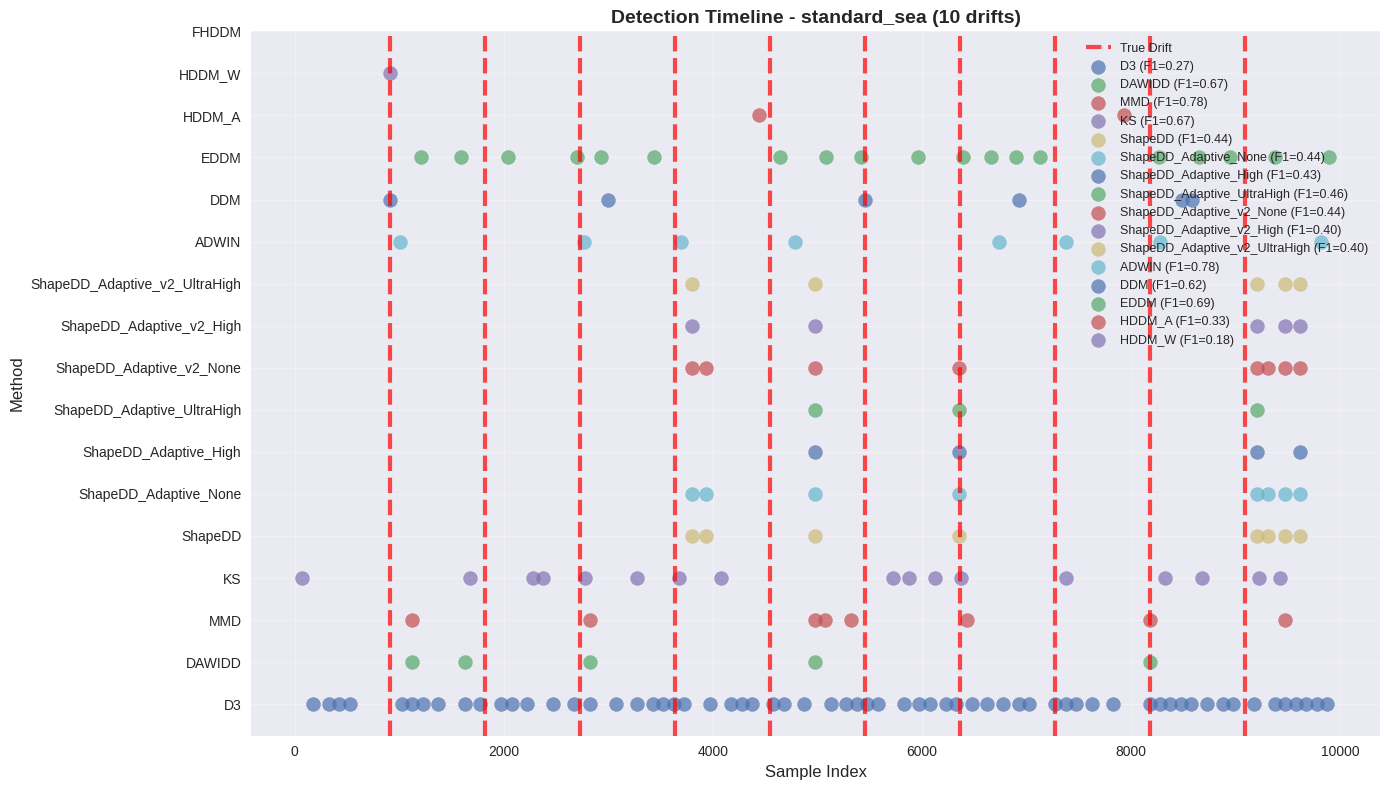

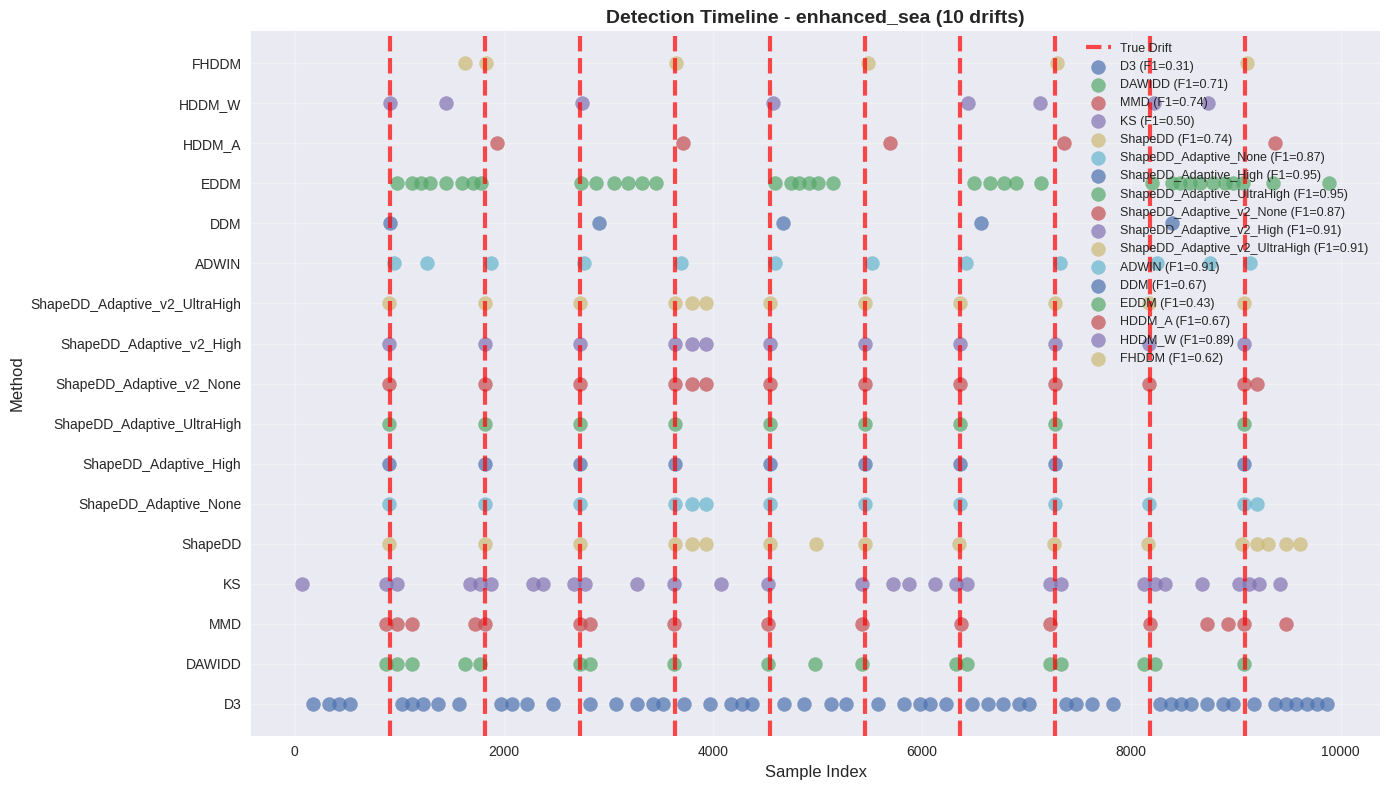

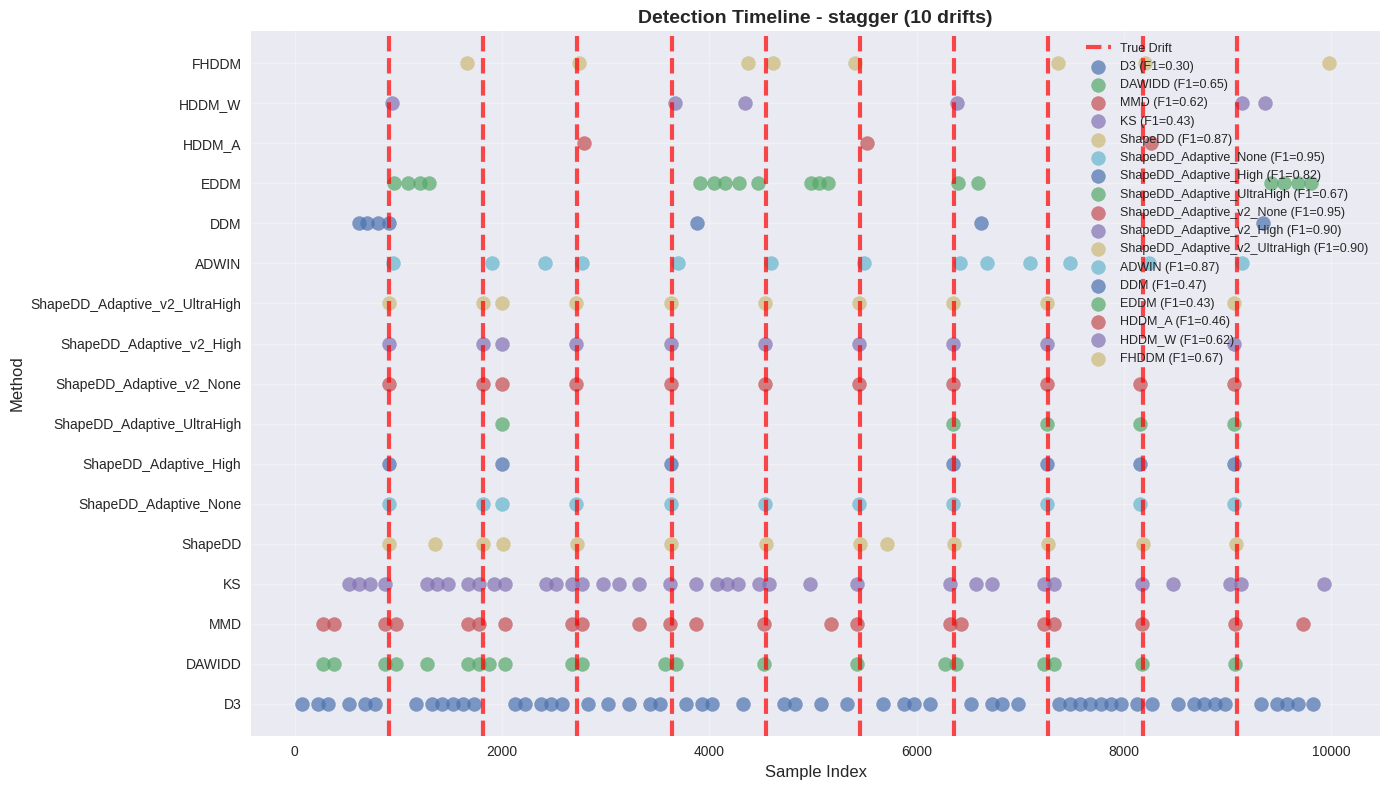

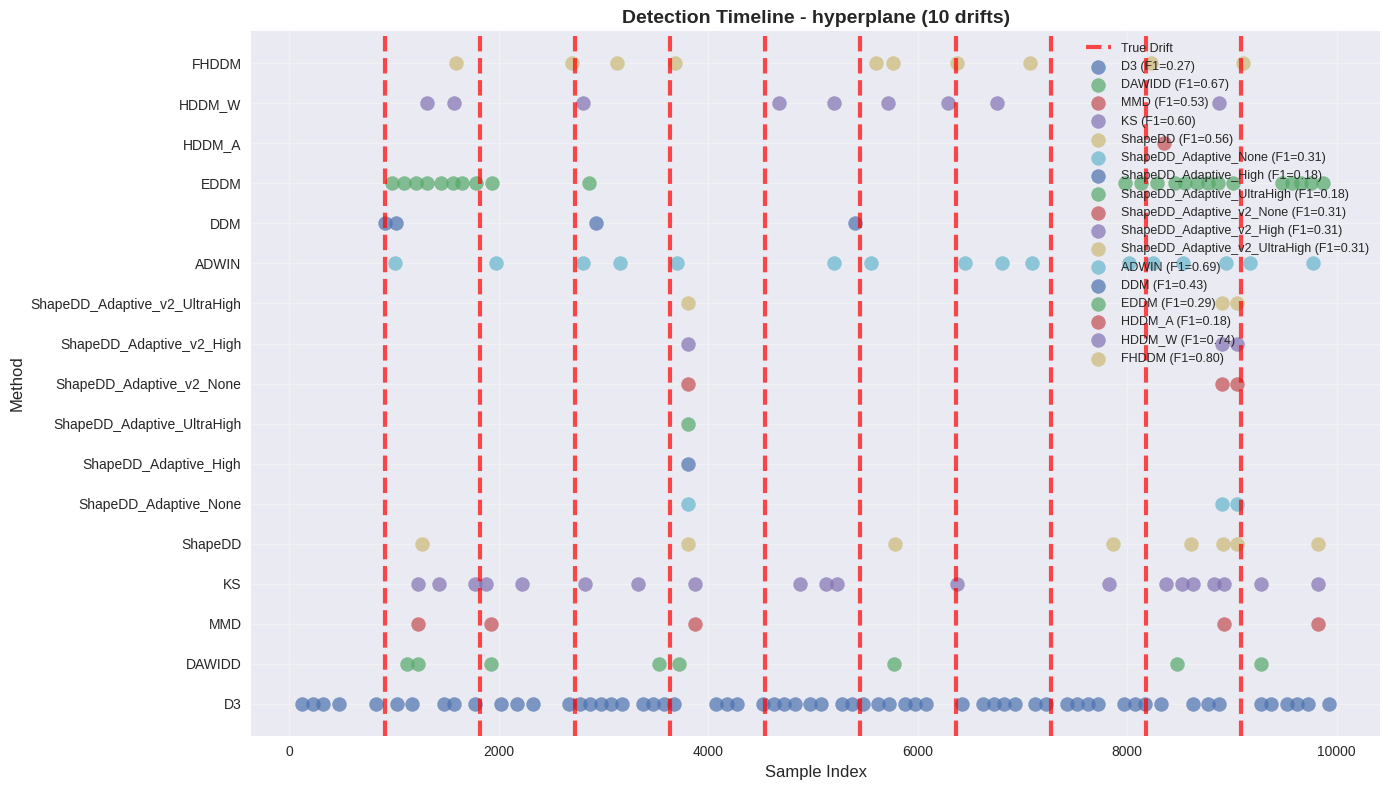

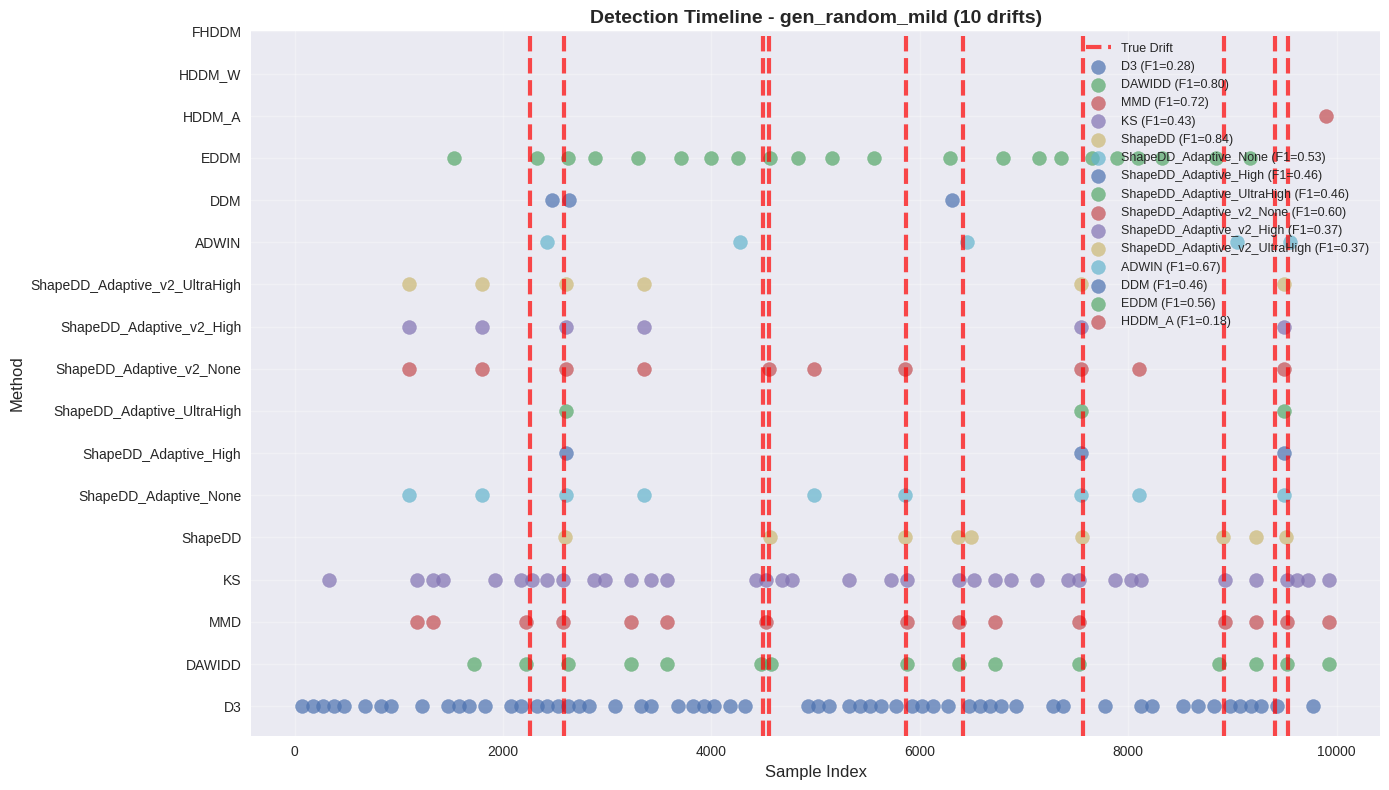

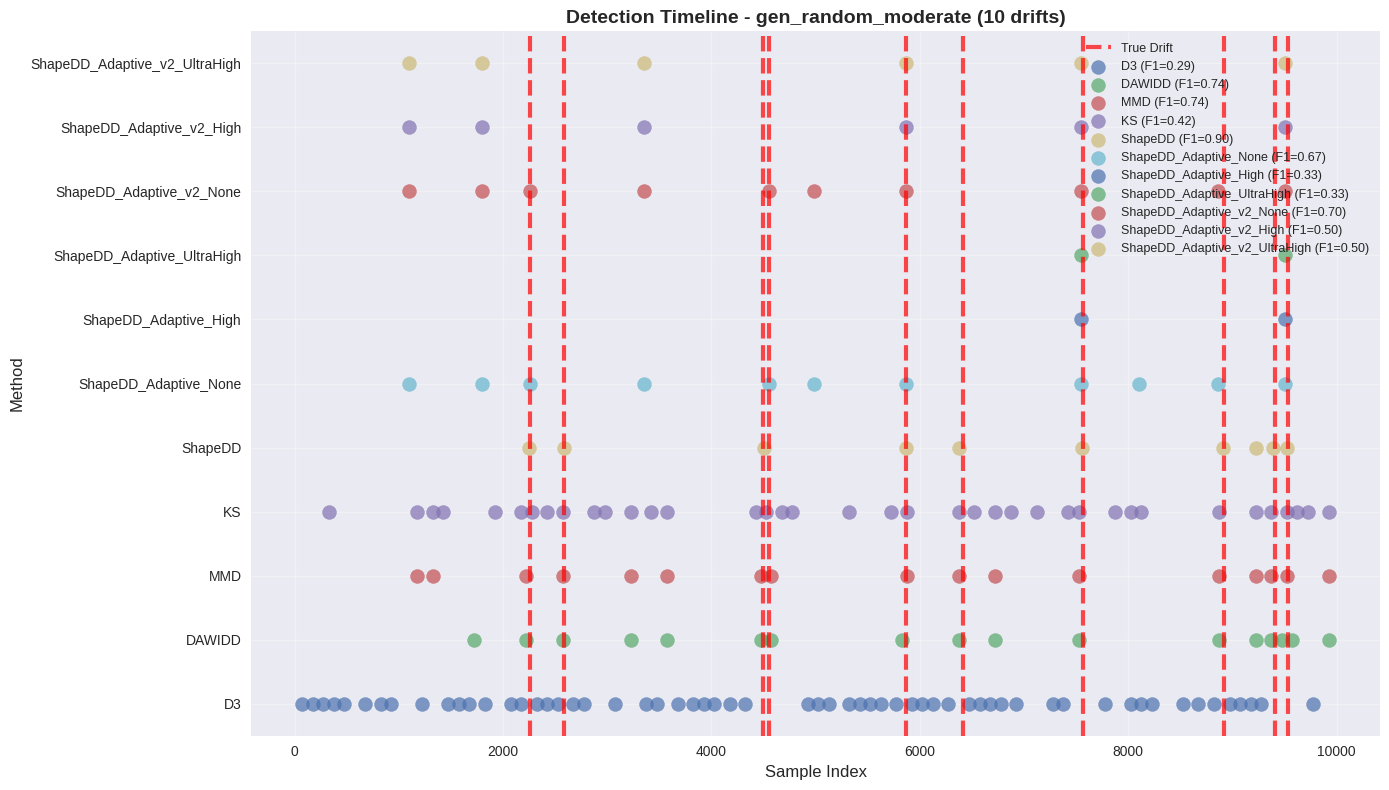

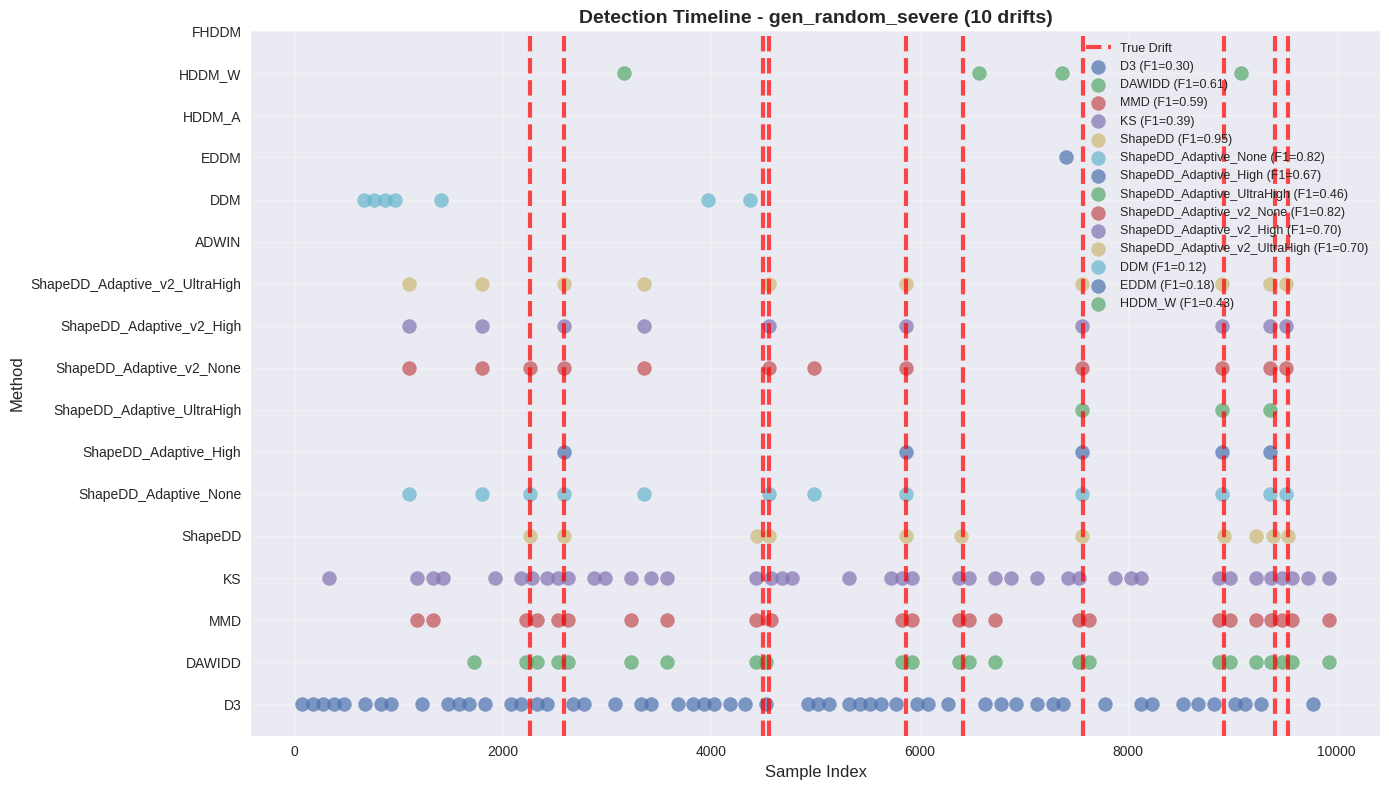

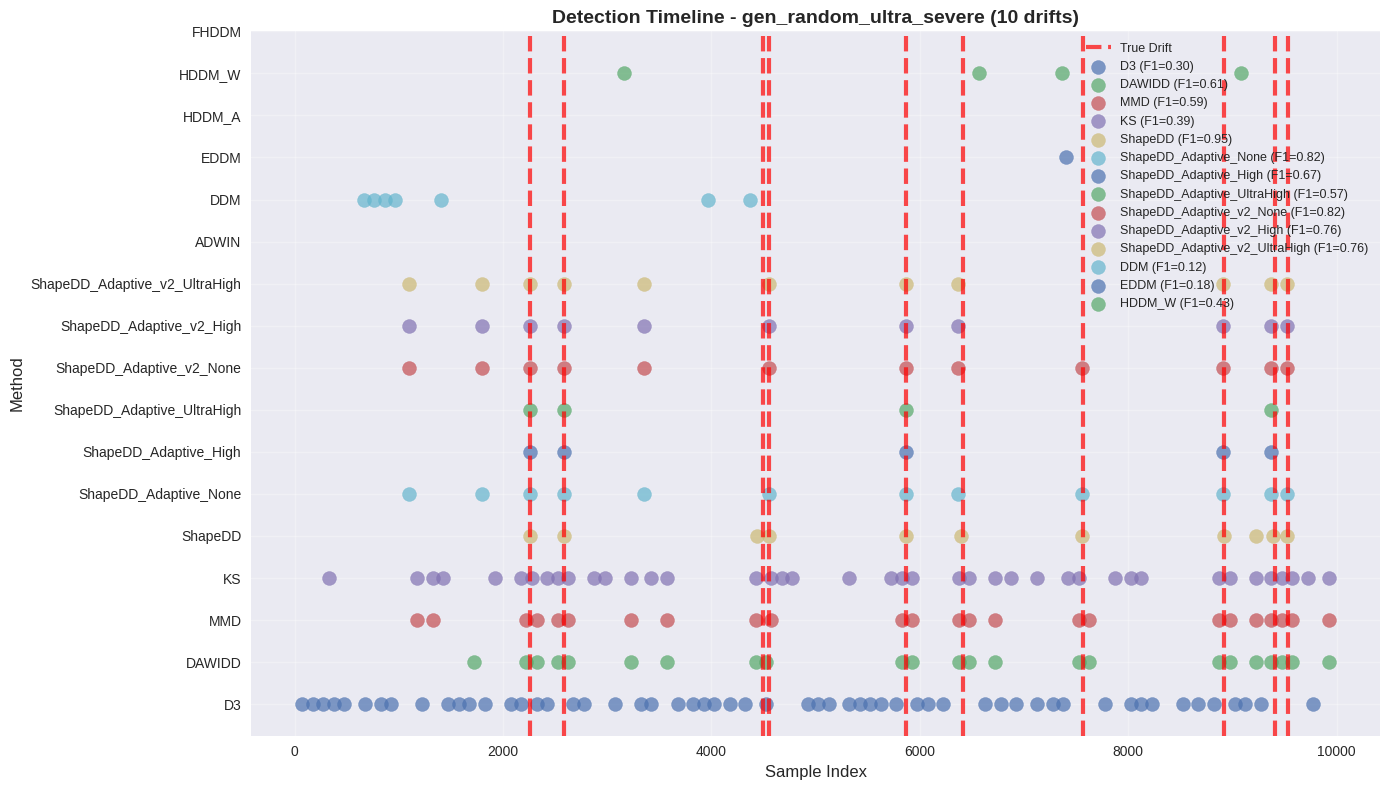

In [9]:
# ============================================================================
# SECTION 8: VISUALIZATION - DETECTION TIMELINES
# ============================================================================

if len(all_results) == 0:
    print("⚠ No results to visualize")
else:
    datasets = results_df['Dataset'].unique()

    for dataset_name in datasets:
        dataset_results = [r for r in all_results if r['dataset'] == dataset_name]

        if not dataset_results:
            continue

        true_drifts = dataset_results[0]['drift_positions']
        n_drifts = len(true_drifts)

        fig, ax = plt.subplots(figsize=(14, 8))

        # Plot true drifts
        for i, drift_pos in enumerate(true_drifts):
            ax.axvline(drift_pos, color='red', linestyle='--', linewidth=3,
                      alpha=0.7, label='True Drift' if i == 0 else '')

        # Plot detections
        for idx, result in enumerate(dataset_results):
            detections = result['detections']
            method = result['method']

            if detections:
                ax.scatter(detections, [idx]*len(detections), s=100, alpha=0.7,
                          label=f"{method} (F1={result['f1_score']:.2f})")

        ax.set_yticks(range(len(dataset_results)))
        ax.set_yticklabels([r['method'] for r in dataset_results])
        ax.set_xlabel('Sample Index', fontsize=12)
        ax.set_ylabel('Method', fontsize=12)
        ax.set_title(f'Detection Timeline - {dataset_name} ({n_drifts} drifts)',
                    fontsize=14, fontweight='bold')
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()



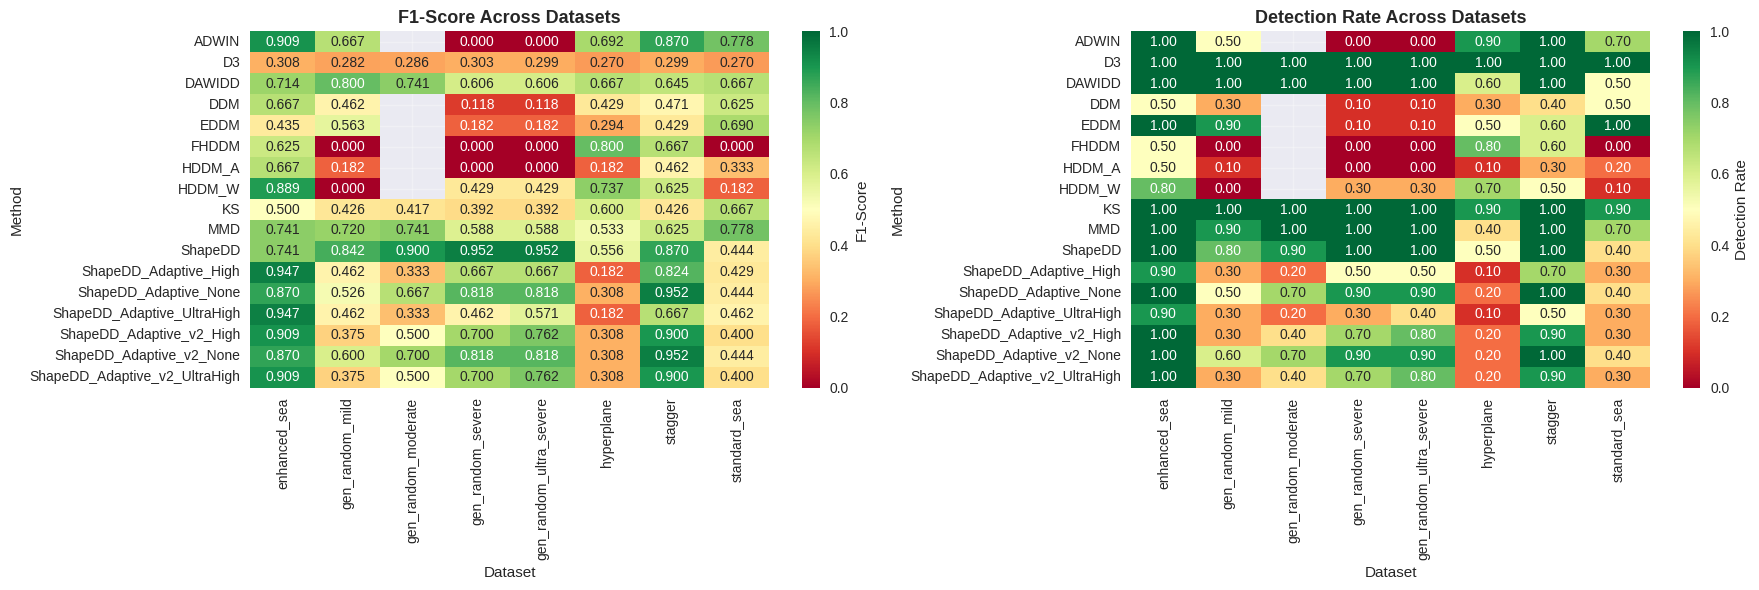

In [10]:
# ============================================================================
# SECTION 9: VISUALIZATION - PERFORMANCE HEATMAP
# ============================================================================

if len(all_results) == 0:
    print("⚠ No results to visualize")
else:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # F1-Score heatmap
    ax = axes[0]
    f1_pivot = results_df.pivot_table(values='F1', index='Method',
                                       columns='Dataset', aggfunc='mean')
    sns.heatmap(f1_pivot, annot=True, fmt='.3f', cmap='RdYlGn',
               vmin=0, vmax=1, cbar_kws={'label': 'F1-Score'}, ax=ax)
    ax.set_title('F1-Score Across Datasets', fontsize=13, fontweight='bold')

    # Detection Rate heatmap
    ax = axes[1]
    dr_pivot = results_df.pivot_table(values='Detection_Rate', index='Method',
                                       columns='Dataset', aggfunc='mean')
    sns.heatmap(dr_pivot, annot=True, fmt='.2f', cmap='RdYlGn',
               vmin=0, vmax=1, cbar_kws={'label': 'Detection Rate'}, ax=ax)
    ax.set_title('Detection Rate Across Datasets', fontsize=13, fontweight='bold')

    plt.tight_layout()
    plt.show()



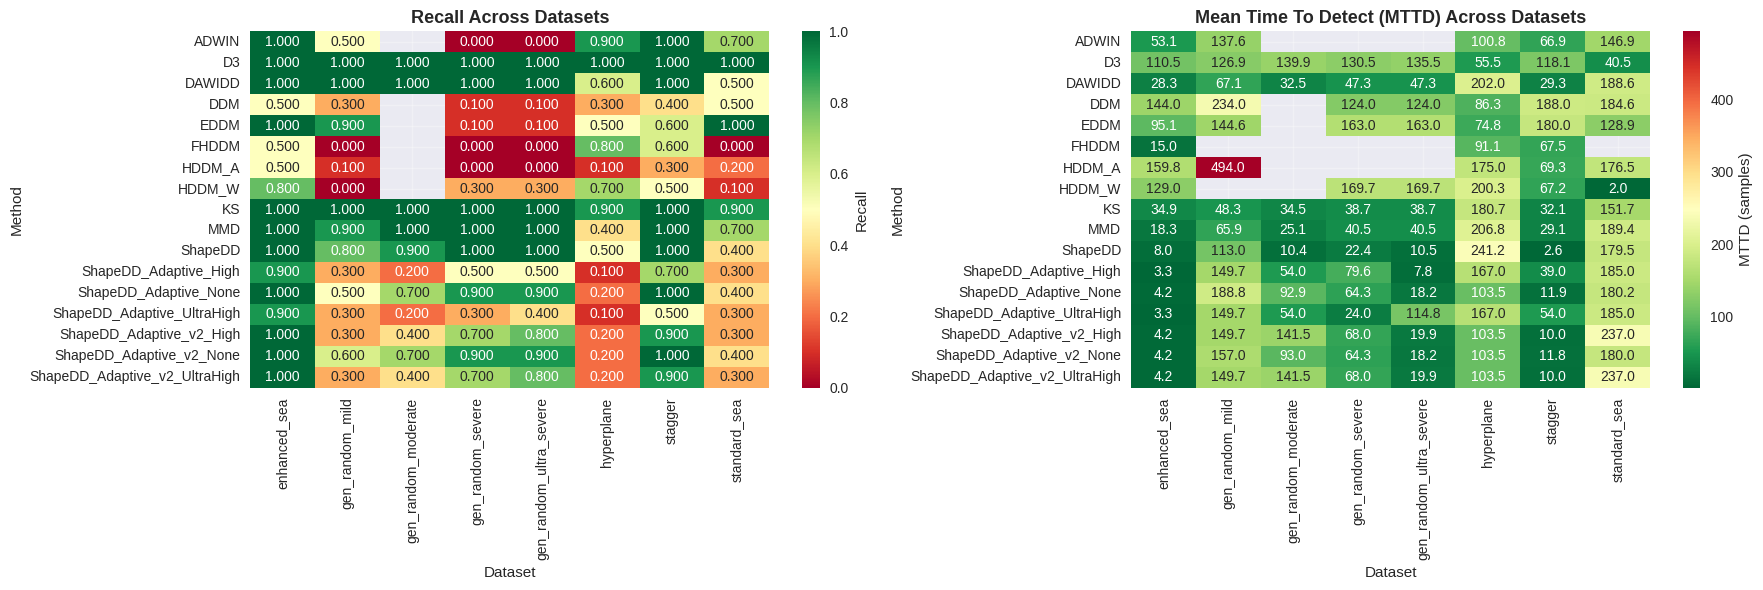

In [11]:
# ============================================================================
# SECTION 10: VISUALIZATION - RECALL AND MTTD HEATMAP
# ============================================================================

if len(all_results) == 0:
    print("⚠ No results to visualize")
else:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Recall heatmap
    ax = axes[0]
    recall_pivot = results_df.pivot_table(values='Recall', index='Method',
                                          columns='Dataset', aggfunc='mean')
    sns.heatmap(recall_pivot, annot=True, fmt='.3f', cmap='RdYlGn',
               vmin=0, vmax=1, cbar_kws={'label': 'Recall'}, ax=ax)
    ax.set_title('Recall Across Datasets', fontsize=13, fontweight='bold')

    # MTTD heatmap
    ax = axes[1]
    mttd_pivot = results_df.pivot_table(values='MTTD', index='Method',
                                        columns='Dataset', aggfunc='mean')
    # Use reverse colormap (lower MTTD is better)
    sns.heatmap(mttd_pivot, annot=True, fmt='.1f', cmap='RdYlGn_r',
               cbar_kws={'label': 'MTTD (samples)'}, ax=ax)
    ax.set_title('Mean Time To Detect (MTTD) Across Datasets', fontsize=13, fontweight='bold')

    plt.tight_layout()
    plt.show()
